# Evaluate commuter data over time
The code below takes labbeled data, trains a NN using a growing amount of training data.
Since this is done itaratively and compared to predictions towards a test set an estimation can be made over how fast the model converges.


In [3]:
#Setup
from fastai import *          # Quick accesss to most common functionality
from fastai.tabular import *  # Quick accesss to tabular functionality     # Access to example data provided with fastai
from fastai.vision import *
PATH="../data/"
dep_var = 'journey'
cat_names = ["detectedActivity","weekday"]
cont_names =["geoHash","minuteOfDay"]
procs = [FillMissing, Categorify, Normalize]
# Uncomment active user
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn

def predict_journeys(learner,dataset):
    "Return"
    result = 0
    accuracy = 0
    for x in range(0,dataset.shape[0]):
        correct = dataset.iloc[x].journey  #remove journey
        predicted = learner.predict(dataset.iloc[x]);
        #print(str(correct)+":"+str(predicted[0]))
        if (str(correct)==str(predicted[0])):
            result=result+1
    accuracy=result/dataset.shape[0]
    return(accuracy)
    
def predict_journey(detectedActivity,geoHash,minuteOfday,weekday):
    data = np.array([['','detectedActivity','geoHash','minuteOfDay','weekday'],
                ["row1",detectedActivity,geoHash,minuteOfday,weekday]])            
    dr=pd.DataFrame(data=data[1:,1:],
                    index=data[1:,0],
                    columns=data[0,1:]).astype(np.int64)
    predicted = learner.predict(dr.iloc[0])
    return(predicted[0],str(round(predicted[2].max().item(),2)))

def evaluate_learner(rows_per_training:int,trainingset,testset,length_teachingSet=0): #Minimal start for any training can bne used for offset
    "Asumes a constant amount of rows per day in training"
    result = []
    if length_teachingSet>0: #do teaching and add thus add startdata for day 0
        start_point = length_teachingSet
    else: #no teachin set exists add row for day 0
        result.append([0,0,0])
        start_point = rows_per_training
    for rows in range(start_point,len(trainingset),rows_per_training):
        df=trainingset[0:rows]
        df=make_shure_we_got_enough_rows(df)
        #valid_idx= list(np.random.randint(0,len(df),int(len(df)*0.1))) #If we want 10% random instead of same 10 rows...
        valid_idx = list(range(int(len(df)*0.9), len(df)))  #Here always last 10% is used for validation
        data = (TabularList.from_df(df, path="models", cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var)
                .databunch())
        learner=tabular_learner(data, layers=[200,100], metrics=accuracy)
        learner.fit_one_cycle(30)
        #learner.fit(5, 1e-2)
        sizeR = len(learner.recorder.metrics)
        resultTest = predict_journeys(learner,testset)
        result.append([rows,learner.recorder.metrics[sizeR-1][0].item(),resultTest])
    return (result)

def evaluate_learner_varying_batch_size(trainingset,testset,length_teachingSet=0):
    "Trains in batches. A new batch starts with -- and ends with next row that starts with --"
    "Training is done from the first row until next row that starts with -- and thus training is done with a growing amount of rows"
    "Rows in a batch are duplicated so there are aways at least 500 rows for training (no new information added and no other data agumentation)"
    "length_teachingset indicates that the dataset starts with a teaching set that consists of length_teachingset rows this is always used for training."
    result = []
    if length_teachingSet>0: #do teaching and thus add startdata for day 0
        start_point = length_teachingSet
    else: 
        result.append([0,0,0]) #no teaching set exists add row for day 0
        start_point = rows_per_training
    for rows in range(start_point,len(trainingset),rows_per_training):
        df=trainingset[0:rows]
        df=make_shure_we_got_enough_rows(df)
        #valid_idx= list(np.random.randint(0,len(df),int(len(df)*0.1))) #If we want 10% random instead of same 10 rows...
        valid_idx = list(range(int(len(df)*0.9), len(df)))  #Here always last 10% is used for validation
        data = (TabularList.from_df(df, path="models", cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var)
                .databunch())
        learner=tabular_learner(data, layers=[200,100], metrics=accuracy)
        learner.fit_one_cycle(30)
        #learner.fit(5, 1e-2)
        sizeR = len(learner.recorder.metrics)
        resultTest = predict_journeys(learner,testset)
        result.append([rows,learner.recorder.metrics[sizeR-1][0].item(),resultTest])
    return (result)

def make_shure_we_got_enough_rows(dataset,minrows=500):
    "If the dataset has fewer rows that minrows, whole dataset copies will be added at the end until at least minrows exists"
    newset = pd.DataFrame()
    while newset.shape[0]<minrows:
        newset = pd.concat([newset,dataset])
    return(newset)

def save_results(filename,result):
    a = np.asarray(result)
    np.savetxt("saved/"+filename,a,delimiter=',',fmt="%10.2f")

### Training iteratively every day
Here we simulate training every day from the start. The result is evaluated towards a testset created from the training set.

In [2]:
%%capture
#Training without teaching set
trainingset = pd.read_csv(PATH+user+"_train_valid.csv")
#Take 14 days
trainingset=trainingset[0:int(trainingset.shape[0]/24)]
testset = pd.read_csv(PATH+user+"_test.csv")
size=trainingset.shape[0]
rows_per_training = int(size/14) # will result in about one training per day
print(rows_per_training)
print(len(trainingset))
resultTrain = evaluate_learner(rows_per_training,trainingset,testset)
save_results("Iterative_"+user+".csv",resultTrain)

### Training with initial teachingset followed by iterative training every day
Here we add a idealised teaching set in the beginning of our dataset. Then we start training from day 0 with all data in the teachingset.

In [2]:
%%capture
#Training with teaching set 
trainingset = pd.read_csv("data/"+user+"_train_valid.csv")
#Take first two weeks
trainingset=trainingset[0:int(trainingset.shape[0]/24)]
size=trainingset.shape[0]
rows_per_training = int(size/14) # will result in about one training per day
teachingset = pd.read_csv(PATH+user+"_teaching_set.csv")
trainingset = pd.concat([teachingset,trainingset])
testset = pd.read_csv(PATH+user+"_test.csv")
resultTeach = evaluate_learner(rows_per_training,trainingset,testset,len(teachingset))
save_results("TeachingIterative_"+user+".csv",resultTeach)

### Show results

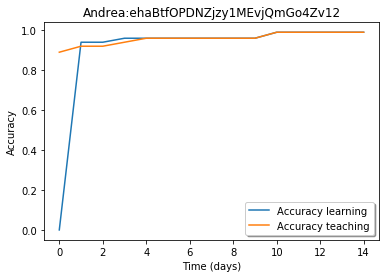

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
personas = pd.read_csv("saved/personas.csv")
#Uncomment to look at individual result
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
personaname = personas.loc[personas['id']==user]
learning_ax0= pd.read_csv("saved/Iterative_"+user+".csv",header=None).values
teaching_ax0 = pd.read_csv("saved/TeachingIterative_"+user+".csv",header=None).values
fig, ax0 = plt.subplots()
ax0.set_title(personaname ['name'].iloc[0]+":"+user)
ax0.plot(learning_ax0[:,2],label='Accuracy learning')
ax0.plot(teaching_ax0[:,2],label='Accuracy teaching')
plt.xlabel('Time (days)')
plt.ylabel('Accuracy')
legend = ax0.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

## Misc

### Teaching
If an idealised teaching set is created that contains all combinations of categorical columns (activity and weekday) combined with a time placed in the middle of the timespan for the scenario and location at the departure station.

epoch,train_loss,valid_loss,accuracy
1,1.219861,1.367606,0.640000
2,0.974029,1.313586,0.640000
3,0.743887,1.158938,0.960000
4,0.570949,0.955995,0.960000
5,0.447231,0.699373,0.960000
6,0.358769,0.480977,1.000000
7,0.293270,0.310816,1.000000
8,0.243769,0.195585,1.000000
9,0.205773,0.122767,1.000000
10,0.176040,0.082974,1.000000


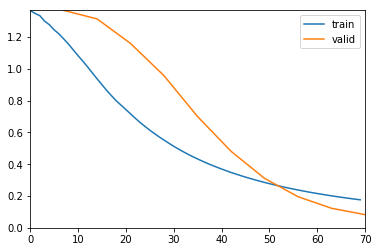

In [5]:
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
filename = user+"_teaching_set.csv"
teachingSet = pd.read_csv(PATH+filename)
teachingSet=make_shure_we_got_enough_rows(teachingSet)
valid_idx= list(np.random.randint(0,len(teachingSet),int(len(teachingSet)*0.1))) #If we want 10% random instead of same 10 rows...
#valid_idx = list(range(int(len(teachingSet)*0.9), len(teachingSet)))  #Here always last 10% is used for validation
data = (TabularList.from_df(teachingSet, path="models", cat_names=cat_names, cont_names=cont_names, procs=procs)
    .split_by_idx(valid_idx)
    .label_from_df(cols=dep_var)
    .databunch())
learner=tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
learner.fit_one_cycle(10)

Predict and view some rows

### Training on parts of data


Run test one cycle with part of the training set.

epoch,train_loss,valid_loss,accuracy
1,1.359575,1.397671,0.300000
2,1.128293,1.361416,0.400000
3,0.905131,1.202348,0.800000
4,0.723228,0.928716,0.900000
5,0.576774,0.662343,1.000000
6,0.465656,0.424139,1.000000
7,0.381444,0.268909,1.000000
8,0.317240,0.177895,1.000000
9,0.267707,0.123318,1.000000
10,0.228828,0.090398,1.000000


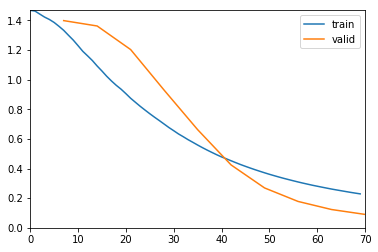

In [2]:
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
filename = user+"_train_valid.csv"
dataSetIn = pd.read_csv(PATH+filename)
dataSet=dataSetIn[0:10]
dataSet=make_shure_we_got_enough_rows(dataSet)
#valid_idx = list(np.random.randint(0,len(dataSet),int(len(dataSet)*0.1)))
valid_idx = list(range(int(len(dataSet)*0.9), len(dataSet)))  #Here always last 10% is used for validation 
data = (TabularList.from_df(dataSet, path="models", cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var)
                .databunch())
learner=tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
#%time learner.fit_one_cycle(10)
learner.fit_one_cycle(10)

### Evaluate on test set

In [3]:
#%%capture
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
filenameTest = user+"_test.csv"
datasetTest = pd.read_csv(PATH+filenameTest)
accuracyTest = predict_journeys(learner,datasetTest)

#### Print result

In [4]:
print(accuracyTest)

0.966804979253112


In [9]:
#prediction,accuracy = predict_journey(3,1243184839,603,6) #8107980000 "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" Andrea
prediction,accuracy = predict_journey(3,1242202139,806,6) #8033880159 "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
#prediction,accuracy = predict_journey(3,1242479279,527,5) #8121680000 "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
print("Predicted journey from: "+str(prediction)[0:5]+" to " +str(prediction)[5:10]+ " with accuracy "+str(accuracy));

Predicted journey from: 80338 to 80159 with accuracy 0.99


### Confusion Matrix and other stuff

In [26]:
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)

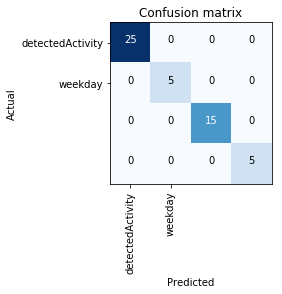

In [27]:
interp.plot_confusion_matrix()

In [123]:
##read 14 days try
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
filenameTest = user+"_start14days.csv"
datasetTest = pd.read_csv(PATH+filenameTest)
trainset = DataFrame(datasetTest[0:0])
for row in datasetTest.itertuples():
    if row[1].startswith('--'):
        print("Starts: "+row[1]) ##New batch
        if len(trainset)>0:
            print("train:"+str(len(trainset)))
    else:
        trainset = trainset.append(datasetTest.iloc[row[0]])
print(trainset)
print(len(trainset))

Starts: --monday--
Starts: --tuesday--
train:6
Starts: --wednesday--
train:13
Starts: --thursday--
train:19
Starts: --friday--
train:29
Starts: --saturday--
train:38
Starts: --sunday--
train:38
Starts: --monday--
train:45
Starts: --tuesday--
train:54
Starts: --wednesday--
train:63
Starts: --thursday--
train:71
Starts: --friday--
train:79
Starts: --saturday--
train:89
Starts: --sunday--
train:95
Starts: --end training data--
train:103
    detectedActivity       geoHash  minuteOfDay  weekday       journey
1                  3  1.243185e+09        443.0      1.0  8.107981e+09
2                  7  1.243185e+09        445.0      1.0  8.107981e+09
3                  3  1.243185e+09        450.0      1.0  8.107981e+09
4                  8  1.242480e+09        920.0      1.0  8.115681e+09
5                  7  1.242480e+09        930.0      1.0  8.115681e+09
6                  3  1.242478e+09        930.0      1.0  8.115681e+09
8                  3  1.243185e+09        490.0      2.0  8.10798